# MOOC User Action Dataset Pipeline: FIGRL test

The dataset used in this experiment can be downloaded through te following link:
http://snap.stanford.edu/data/act-mooc.html

In [1]:
# Global parameters:
embedding_size = 64
add_additional_data = True

## 1. Loading the MOOC Dataset

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import time
import networkx as nx
import stellargraph as sg
import scipy
from scipy.sparse import csr
import scipy.sparse

The action file has following attributes:

ACTIONID: a unique id for each action.

USERID: a unique id for each user.

TARGETID: a unique id for each target activity.

TIMESTAMP: timestamp for the action in seconds from the beginning.

In [3]:
df_action = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\FIGRL_Uit_Matlab\\datasets\\mooc_actions.tsv", sep='\t')

df_action = df_action.set_index('ACTIONID')
pd.Series(df_action.index).is_unique

True

The feature file has following attributes:

ACTIONID: a unique id for each action.

FEATUREx: a feature value associated with the action. Total four in count, making it a 4-dimensional feature vector

In [4]:
df_feature = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\FIGRL_Uit_Matlab\\datasets\\mooc_action_features.tsv", sep='\t')

df_feature = df_feature.set_index('ACTIONID')
pd.Series(df_feature.index).is_unique

True

The lable file has following attributes:
    
ACTIONID: a unique id for each action.
    
LABEL: a binary label indicating whether the student drops-out after the action. The value is 1 for drop-out actions, 0 otherwise.

In [5]:
df_labels = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\FIGRL_Uit_Matlab\\datasets\\mooc_action_labels.tsv", sep='\t')
df_labels = df_labels.drop(columns='ACTIONID')
df_labels.index.name = 'ACTIONID'

pd.Series(df_labels.index).is_unique

True

In [6]:
df = pd.merge(df_action, df_feature.loc[df_action.index], left_index=True, right_index=True)
df = pd.merge(df, df_labels.loc[df.index], left_index=True, right_index=True)
pd.Series(df.index).is_unique

True

In [7]:
df['USERID']+=max(df.index)+1
df['TARGETID']+=max(df.USERID)+1
print(min(df.TARGETID))

418796


In [8]:
cutoff = round(0.6*len(df))
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [9]:
print('The distribution of banned pages for the train data is:\n', train_data['LABEL'].value_counts())
print('The distribution of banned pages for the inductive data is:\n', inductive_data['LABEL'].value_counts())

The distribution of banned pages for the train data is:
 0    244461
1      2588
Name: LABEL, dtype: int64
The distribution of banned pages for the inductive data is:
 0    163222
1      1478
Name: LABEL, dtype: int64


## 2. Construct the Graph Network

A networkx graph is constructed with edit, user and webpage nodes. Creating a three partite graph. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [10]:
from components.GraphConstruction import GraphConstruction

action_data = train_data.drop("USERID", axis=1).drop("TARGETID", axis=1).drop("LABEL", axis=1).drop("TIMESTAMP", axis=1)
USERID_data = pd.DataFrame([1]*len(train_data.USERID.unique())).set_index(train_data.USERID.unique())
TARGETID_data = pd.DataFrame([1]*len(train_data.TARGETID.unique())).set_index(train_data.TARGETID.unique())

nodes = {"USERID":train_data.USERID, "TARGETID":train_data.TARGETID, "action":train_data.index}
edges = [zip(train_data.USERID, train_data.index),zip(train_data.TARGETID, train_data.index)]
features = {"action": action_data, 'USERID': USERID_data, 'TARGETID': TARGETID_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 253389, Edges: 494098

 Node types:
  action: [247049]
    Features: float32 vector, length 4
    Edge types: action-default->TARGETID, action-default->USERID
  USERID: [6262]
    Features: float32 vector, length 1
    Edge types: USERID-default->action
  TARGETID: [78]
    Features: float32 vector, length 1
    Edge types: TARGETID-default->action

 Edge types:
    USERID-default->action: [247049]
        Weights: all 1 (default)
        Features: none
    TARGETID-default->action: [247049]
        Weights: all 1 (default)
        Features: none


## 3. Train HinSAGE

HinSAGE, a heterogeneous implementation of the GraphSAGE framework is trained with user specified hyperparameters.

In [11]:
from components.HinSAGE import HinSAGE_Representation_Learner

#GraphSAGE parameters
num_samples = [2,32]
embedding_node_type = "action"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['LABEL'], batch_size=5, epochs=10)

Epoch 1/10
39528/39528 [==============================] - 119s 3ms/step - loss: 0.0537 - val_loss: 0.0439
Epoch 2/10
39528/39528 [==============================] - 119s 3ms/step - loss: 0.0512 - val_loss: 0.0439
Epoch 3/10
39528/39528 [==============================] - 118s 3ms/step - loss: 0.0506 - val_loss: 0.0438
Epoch 4/10
39528/39528 [==============================] - 118s 3ms/step - loss: 0.0506 - val_loss: 0.0432
Epoch 5/10
39528/39528 [==============================] - 122s 3ms/step - loss: 0.0505 - val_loss: 0.0445
Epoch 6/10
39528/39528 [==============================] - 119s 3ms/step - loss: 0.0503 - val_loss: 0.0434
Epoch 7/10
39528/39528 [==============================] - 118s 3ms/step - loss: 0.0503 - val_loss: 0.0453
Epoch 8/10
39528/39528 [==============================] - 122s 3ms/step - loss: 0.0502 - val_loss: 0.0437
Epoch 9/10
39528/39528 [==============================] - 123s 3ms/step - loss: 0.0501 - val_loss: 0.0435
Epoch 10/10
39528/39528 [=====================

## 4. Inductive Step HinSAGE

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [12]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

For the inductive step, we need to add the new, unseen transactions to the graph. Because the current StellarGraph implementation does not support adding nodes and edges to an existing stellargraph object, we create a new graph that contains all the nodes from the train graph in addition to the new nodes.

In [13]:
action_data = inductive_graph_data.drop("USERID", axis=1).drop("TARGETID", axis=1).drop("LABEL", axis=1).drop("TIMESTAMP", axis=1)
USERID_data = pd.DataFrame([1]*len(inductive_graph_data.USERID.unique())).set_index(inductive_graph_data.USERID.unique())
TARGETID_data = pd.DataFrame([1]*len(inductive_graph_data.TARGETID.unique())).set_index(inductive_graph_data.TARGETID.unique())

nodes = {"USERID":inductive_graph_data.USERID, "TARGETID":inductive_graph_data.TARGETID, "action":inductive_graph_data.index}
edges = [zip(inductive_graph_data.USERID, inductive_graph_data.index),zip(inductive_graph_data.TARGETID, inductive_graph_data.index)]
features = {"action": action_data, 'USERID': USERID_data, 'TARGETID': TARGETID_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 418893, Edges: 823498

 Node types:
  action: [411749]
    Features: float32 vector, length 4
    Edge types: action-default->TARGETID, action-default->USERID
  USERID: [7047]
    Features: float32 vector, length 1
    Edge types: USERID-default->action
  TARGETID: [97]
    Features: float32 vector, length 1
    Edge types: TARGETID-default->action

 Edge types:
    USERID-default->action: [411749]
        Weights: all 1 (default)
        Features: none
    TARGETID-default->action: [411749]
        Weights: all 1 (default)
        Features: none


In [14]:
inductive_emb = hinsage.inductive_step_hinsage(S, trained_hinsage_model, inductive_data.index, batch_size=5)

32940/32940 [==============================] - 96s 3ms/step


## 5. Classification

In [15]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [16]:
train_labels = train_data['LABEL']

if add_additional_data is True:
    train_emb = pd.merge(train_emb, train_data.loc[train_emb.index].drop('LABEL', axis=1), left_index=True, right_index=True)
    inductive_emb = pd.merge(inductive_emb, inductive_data.loc[inductive_emb.index].drop('LABEL', axis=1), left_index=True, right_index=True)
baseline_train = train_data.drop('LABEL', axis=1)
baseline_inductive = inductive_data.drop('LABEL', axis=1)

classifier.fit(baseline_train, train_labels)
baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(train_emb, train_labels)
predictions = classifier.predict_proba(inductive_emb)


## 6. Evaluation

Average precision-recall score for  GraphSAGE+features  configuration XGBoost: 0.0519896388
Average precision-recall score for  Baseline  configuration XGBoost: 0.0284690267


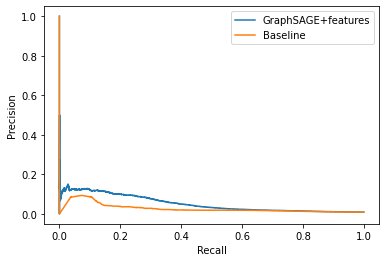

In [17]:
from components.Evaluation import Evaluation
inductive_labels = df.loc[inductive_emb.index]['LABEL']

graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
graphsage_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()